### **1. Import Dependencies**

In [1]:
import pandas as pd
import numpy as np

import gc
import os
import requests
import json
import re

import concurrent.futures

from urllib.parse import urlencode

from typing import List, Dict, Optional, Union
from glob import glob

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, f1_score

from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors 

import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Bidirectional, Input, Reshape, Dot, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

import faiss

nltk.download('stopwords')
nltk.download('punkt')

d:\Project\Python\End to End Projects\Bug Classification\Notebook\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2. Settings**

In [2]:
tf.random.set_seed(42)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### **3. Load Data**

Fetch the bug report data using [BugZilla API](https://bmo.readthedocs.io/en/latest/api/core/v1/bug.html#get-bug) then save it as json and Pandas.parquet.

In [222]:
def fetch_data(url: str, params=None):
  try:
    response = requests.get(url, params=params)
    if (response.status_code == 200):
      return response.json()
    
    print(f"Error response with status code: {response.status_code}")
  except Exception as error:
    print(f'Failed to fetch data: {error}')

def urls_builder(base_url: str, n_fetch: int, limit: int, products: List[str], **kwargs):
  urls = []
  for product in products:
    for i in range(n_fetch):
      
      param = {
        'offset': i * limit,
        'limit': limit,
        'product': product,
        **kwargs,
      }
      
      full_url = base_url + '?' + urlencode(param)
      urls.append(full_url)
    
  return urls

def save_json(data, path: str):
  with open(path, 'w') as json_file:
    json.dump(data, json_file)

def load_json(path: str):
  with open(path, 'r') as json_file:
    loaded_data = json.load(json_file)
  return loaded_data

In [15]:
# %%script skipped # Skipped 

selected_fields = ['id', 'duplicates', 'summary', 'description', 'status', 'resolution', 'platform', 'product', 'type', 'priority', 'severity', 'component']
products = ['Firefox']

base_params = {'include_fields': ', '.join(selected_fields)}
saved_data_path = os.path.join('data', 'raw_data', 'firefox_raw_data.json')

base_url = 'https://bugzilla.mozilla.org/rest/bug'
n_fetch, limit = 50, 100

if os.path.exists(saved_data_path):
  response_data = load_json(saved_data_path)
else:
  urls = urls_builder(base_url, n_fetch, limit, products, **base_params)
  response_data = []

  max_workers = 50
  with concurrent.futures.ThreadPoolExecutor(max_workers) as executor:
    response_data = list(executor.map(fetch_data, urls))
    
  response_data = [item['bugs'] for item in response_data]
  response_data = [item for sublist in response_data for item in sublist]
  
  save_json(response_data, saved_data_path)

In [3]:
raw_data_path = os.path.join('data', 'cache', 'raw_data.parquet')
df = pd.DataFrame()

if (os.path.exists(raw_data_path)):
  df = pd.read_parquet(raw_data_path)
else:
  data_paths = glob(os.path.join('data', 'raw_data', 'firefox_raw_data.json'))

  for path in data_paths:
    data = load_json(path)
    data = pd.DataFrame(data)
    df = pd.concat([df, data])

  df = df.set_index('id')
  df.to_parquet(raw_data_path)

df.head()

,component,status,resolution,summary,description,product,duplicates,severity,priority,type,platform
id,,,,,,,,,,,
10954,Settings UI,RESOLVED,WONTFIX,Dialup properties needs to be exposed in prefs,The dialup properties of the profile should be...,Firefox,[],normal,P3,enhancement,All
14871,General,RESOLVED,DUPLICATE,[Find] Find whole word only,"Please add ""Match Whole Word Only"" option to b...",Firefox,[],minor,--,defect,All
19118,Settings UI,RESOLVED,WONTFIX,Plug-In Manager (ui for choosing mimetype-plug...,I would really like a plug-in manager for my b...,Firefox,"[32380, 57760, 64040, 66644, 95646, 96695, 106...",normal,--,enhancement,All
21482,File Handling,NEW,,Improvement to Save File dialog: folder based ...,Perhaps this really should be in the standardi...,Firefox,[],S3,P3,enhancement,All
23207,File Handling,NEW,,"Options in Save As (location of saved images, ...",Save as... feature should be extended in follo...,Firefox,"[26366, 172317, 177285]",S3,P5,enhancement,Unspecified


In [4]:
df = df.drop(['status', 'priority', 'resolution', 'severity', 'component', 'product', 'type'], axis=1)

gc.collect()

43

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 210693 entries, 10954 to 1876223
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   summary      210693 non-null  object
 1   description  210693 non-null  object
 2   duplicates   210693 non-null  object
 3   platform     210693 non-null  object
dtypes: object(4)
memory usage: 291.5 MB


### **3. EDA**

### **3.1. Missing Values**

It seems there is no missing value

In [6]:
df.isna().sum()

summary        0
description    0
duplicates     0
platform       0
dtype: int64

### **3.2. Product**

In [13]:
%%script skipped # Skipped

df['product'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.3. Platform**

In [28]:
df['platform'].value_counts(ascending=False)

platform
x86            80884
Unspecified    39764
All            28530
x86_64         19096
PowerPC         6273
Desktop         4625
Other            727
ARM              188
Sun              181
ARM64             51
HP                24
DEC                7
SGI                6
RISCV64            3
XScale             2
Name: count, dtype: int64

### **3.4. Type**

In [16]:
%%script skipped # Skipped

df['type'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.5. Duplicates**

We see that there are 15k bug reports are considered duplicated by other reports

In [ ]:
duplicates = df['duplicates'].apply(lambda x: len(x)).sort_values(ascending=False)

duplicated_bugs = duplicates[duplicates > 0]
duplicated_bugs.count()

id
246078     114
247116      73
210910      69
69938       68
245392      66
          ... 
505579       0
505620       0
505621       0
505622       0
1876223      0
Name: duplicates, Length: 210405, dtype: int64

### **4. Feature Engineering**

### **4.1. Missing Values**

In [32]:
%%script skipped # Skipped

df.loc[df['type'] == '--', 'type'] = 'no type'

Couldn't find program: 'skipped'


### **4.2. Duplicates**

In [7]:
df = df.loc[df.astype(str).drop_duplicates(keep='first').index]

### **4.2. Duplicates**

Currently we have data that has field called `'duplicates'` which is a list of report ids that considered has the same context. To make the data usable, add new feature called `'duplicates_to'` that inferred from `'duplicates'` field.

In [11]:
duplicated = df.loc[duplicated_bugs.index, 'duplicates']
duplicated

id
246078     [239385, 239561, 246164, 246674, 246958, 24697...
247116     [247032, 254990, 255342, 256792, 257710, 25950...
210910     [197227, 210933, 211542, 212349, 212382, 21269...
69938      [79637, 87494, 105392, 107129, 116505, 121880,...
245392     [245393, 245694, 246339, 246486, 247750, 24788...
                                 ...                        
1347170                                            [1347627]
1349552                                            [1371769]
672630                                              [974724]
256622                                              [264107]
255160                                              [251051]
Name: duplicates, Length: 15140, dtype: object

In [12]:
data_path = os.path.join('data', 'cache', 'duplicate_to_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['duplicates_to'] = -1

  for idx, dups in zip(duplicated.index, duplicated):
    for item in dups:
      df.loc[df.index == item, 'duplicates_to'] = idx
      
  df.to_parquet(data_path)

In [13]:
df = df.drop(columns=['duplicates'])

### **4.4. Combined Text**

In [15]:
df['text'] = df['platform'] + ' ' + df['summary'] + ' ' + df['description']

In [16]:
df = df[['text', 'duplicates_to']]

df.head()

,text,duplicates_to
id,,
10954,dialup properties needs exposed prefs dialup ...,-1
14871,find find whole word please add match whole w...,-1
19118,plug manager ui choosing mimetype plugin asso...,-1
21482,improvement save file dialog folder based url...,-1
23207,unspecified options save location saved images...,-1


### **4.3. Clean Sentences**

Remove non-alphanumeric, newline, tab, return, single character, and multiple spaces. We also removing stopwords by utilizing stopwords provided by `nltk` library 

In [14]:
def remove_special_chars(text: str):
  text = text.lower()
  text = re.sub(r'\n|\t|\r|\0', ' ', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  text = re.sub(r'\s$', '', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  return text


def remove_stopwords(text: str):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)


def clean_text(text: str):
  text = remove_special_chars(text)
  text = remove_stopwords(text)
  return text


df['text'] = df['text'].apply(clean_text)

### **4.5. Sentence Embedding**

We use pretrained embedding model to vectorize the text, there are 2 methods that we try in this project, **Sentence Transformer (all-MiniLM-L6-v2)** and **Fasttext**.

### **4.5.1. Sentence Transformers**

Based on the [all-MiniLM-L6-v2 page](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), we know that all-MiniLM-L6-v2 use 384 dense vector to represent a sentence. This model intended to be used as a sentence and short paragraph encoder that limited to 256 word pieces (longer that that will be truncated) that means, *there are some text will not be able to vectorize with full context*.

In [39]:
# %%script skipped # Skipped
sent_embd_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [404]:
# %%script skipped # Skipped

num_dim = 384
embd_data_path = os.path.join('data', 'cache', 'sent_trans_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sent_embd_model.encode)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

94771

### **4.5.2. Fasttext**

Basically `Fasttext` is used for word embedding, to get sentence vector, we simply use normalized average word vector among sentence. Normalization used because our objective is to determining similarity between texts/sentences. The advantages of using `Fasttext` besides it much faster, we also able to capture full context on every sentence because there is no sentence length limitation.

In [17]:
%%script skipped # Skipped

model_path = os.path.join('models', 'wiki-news-300d-1M-subword.vec')
sent_embd_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [18]:
%%script skipped # Skipped

def sentence_embedding(sentence, model):
    words = word_tokenize(sentence)
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        return None

    embedding = np.mean([model[word] for word in words_in_vocab], axis=0)
    embedding = normalize(embedding.reshape(1, -1), norm='l2').reshape(-1)

    return embedding

In [97]:
%%script skipped # Skipped

num_dim = 300
embd_data_path = os.path.join('data', 'cache', 'fasttext_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sentence_embedding, model=sent_embd_model)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

20325

In [405]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 210693 entries, 10954 to 1876223
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           210693 non-null  object
 1   duplicates_to  210693 non-null  int64 
 2   text_embedded  210693 non-null  object
dtypes: int64(1), object(2)
memory usage: 517.7 MB


### **4.6. Sentence Pairs**

We create sentence pairs and label them whether both unique or duplicated report

In [406]:
df = df.reset_index()

In [407]:
df_duplicates = df[df['duplicates_to'] != -1].copy()
df_uniques = df[df['duplicates_to'] == -1].copy()

In [408]:
df_duplicates = pd.merge(left=df_duplicates,
                        right=df_uniques,
                        left_on='duplicates_to',
                        right_on='id',
                        suffixes=('__left', '__right'))
df_duplicates = df_duplicates.drop(columns=['duplicates_to__left', 'duplicates_to__right'])
df_duplicates['label'] = 1
df_duplicates = df_duplicates.reset_index(drop=True)

df_duplicates.head()

,id__left,text__left,text_embedded__left,id__right,text__right,text_embedded__right,label
0,46407,enhancement current url querried another app ...,"[-0.03849341, 0.044417124, 0.061231103, 0.0028...",516502,defect add applescript support getting curren...,"[-0.068924494, -0.0365692, 0.017821774, -0.005...",1
1,95091,defect x86 helper application lack mozilla 0 9...,"[-0.07100523, -0.028381774, 0.023365201, 0.037...",57420,defect support helper app command line args u...,"[0.030665655, -0.08451681, -0.060907457, -0.08...",1
2,134649,defect powerpc browser urlbar clickselectsall ...,"[-0.028466182, 0.010100972, 0.039920595, 0.120...",409810,defect powerpc clicking location bar selects w...,"[-0.022986848, -0.040886015, 0.040972777, 0.05...",1
3,141706,defect xx mail address specified href mailto ...,"[-0.03694004, -0.014539962, 0.027701173, 0.038...",1781264,defect x86 64 encoded umlauts c3 bc passed dec...,"[-0.031441327, -0.041367855, 0.06764637, -0.02...",1
4,153509,enhancement x86 allow search engines test defa...,"[-0.0180947, -0.05431543, 0.026843896, -3.4008...",340604,enhancement implement ie window external isse...,"[-0.13558964, -0.017756177, -0.021699434, 0.04...",1


In [409]:
half_rows = df_uniques.shape[0] // 2
df_uniques = df_uniques.sample(frac=1, replace=False, random_state=42)

df_uniques_temp = pd.DataFrame()
df_uniques_temp['text_embedded__left'] = df_uniques['text_embedded']
df_uniques_temp['text__left'] = df_uniques['text']
df_uniques_temp['id__left'] = df_uniques['id']

df_uniques_temp['text_embedded__right'] = df_uniques['text_embedded'].shift(1)
df_uniques_temp['text__right'] = df_uniques['text'].shift(1)
df_uniques_temp['id__right'] = df_uniques['id'].shift(1)

df_uniques_temp = df_uniques_temp.dropna()
df_uniques_temp['label'] = 0

df_uniques = df_uniques_temp.reset_index(drop=True)

del df_uniques_temp
gc.collect()

df_uniques.head()

,text_embedded__left,text__left,id__left,text_embedded__right,text__right,id__right,label
0,"[0.013469558, -0.010111869, 0.028897135, -0.00...",defect x86 search without dialog new search di...,264962,"[-0.012708805, 0.036860116, 0.09029018, 0.1036...",defect x86 getelementsbytagname confused short...,293692.0,0
1,"[-0.05257168, -0.01263137, 0.089446604, -0.017...",defect unspecified colour updates needed new t...,1451474,"[0.013469558, -0.010111869, 0.028897135, -0.00...",defect x86 search without dialog new search di...,264962.0,0
2,"[-0.0056334394, -0.014998359, 0.036152463, 0.0...",defect x86 64 one word urlbar searches incredi...,972452,"[-0.05257168, -0.01263137, 0.089446604, -0.017...",defect unspecified colour updates needed new t...,1451474.0,0
3,"[-0.03328692, -0.017311642, 0.02710121, -0.015...",defect x86 firefox installer handle directory ...,341797,"[-0.0056334394, -0.014998359, 0.036152463, 0.0...",defect x86 64 one word urlbar searches incredi...,972452.0,0
4,"[0.04823823, -0.0018696992, -0.056124125, -0.0...",defect x86 firefox 18 0b1 b2 segmentation faul...,817482,"[-0.03328692, -0.017311642, 0.02710121, -0.015...",defect x86 firefox installer handle directory ...,341797.0,0


In [410]:
df = pd.concat([df_duplicates, df_uniques], axis=0).sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
gc.collect()

0

### **5. Data Split**

### **5.1. Train Test Split**

In [411]:
X, X_test, y, y_test = train_test_split(df[['text_embedded__left', 'text_embedded__right']],
                                        df['label'],
                                        shuffle=True,
                                        stratify=df['label'],
                                        test_size=0.3,
                                        random_state=42)

print(f'Shape of X_train: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (146384, 2)
Shape of X_test: (62737, 2)
Shape of y_train: (146384,)
Shape of y_test: (62737,)


### **5.2. Data Fold**

Using 5 stratified fold

In [412]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **6. Model Preparation**

We build 2 model, first is using dense layer and the second is using lstm

### **6.1. Dense Embedding**

The model constructed using 2 inputs, a fully connected layer (acting as latent layer), a similarity layer (using normalized dot product), then last layer is a fully connected with sigmoid activation.

In [351]:
# %%script skipped # Skipped

input_1 = Input(shape=(num_dim, ), name='input_1')
input_2 = Input(shape=(num_dim, ), name='input_2')

shared_node_1 = Dense(256, activation='linear', name='shared_node_1')

x1 = shared_node_1(input_1)
x2 = shared_node_1(input_2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 shared_node_1 (Dense)       (None, 256)                  98560     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 cosine_similarity (Dot)     (None, 1)                    0         ['shared_node_1[0

### **6.2. LSTM Embedding**

The model constructed using 2 inputs, an LSTM layer (return  a sequence that acting as latent layer), a 1D global average pooling layer, a similarity layer (using normalized dot product), then last layer is a fully connected with sigmoid activation.

In [346]:
%%script skipped # Skipped

input_1 = Input(shape=(300, ), name='input_1')
input_2 = Input(shape=(300, ), name='input_2')

reshape_node = Reshape((1, 300), input_shape=(300, ), name='reshape_node_1')

shared_node_1 = Bidirectional(LSTM(256, return_sequences=True, input_shape=(1, 300)), name='shared_node_1')
shared_node_2 = GlobalAveragePooling1D(name='shared_node_2')

x1 = reshape_node(input_1)
x1 = shared_node_1(x1)
x1 = shared_node_2(x1)

x2 = reshape_node(input_2)
x2 = shared_node_1(x2)
x2 = shared_node_2(x2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()

Couldn't find program: 'skipped'


### **7. Model Training**

### **7.1. Traning Preparation**

In [352]:
tf.random.set_seed(42)
gc.collect()

5137

In [353]:
def train_model(X_train, X_valid, y_train, y_valid, batch_size, epochs, callbacks=None, verbose='auto'):
  history = training_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[*callbacks],
    verbose=verbose)
    
  train_score = training_model.evaluate(X_train, y_train, verbose=verbose)[1:]
  valid_score = training_model.evaluate(X_valid, y_valid, verbose=verbose)[1:]
  
  return [train_score, valid_score, history]

### **7.2. Model Training**

In [354]:
epochs = 30
batch_size = 64

train_scores = []
valid_scores = []
histories = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train_inputs = [np.vstack(X_train['text_embedded__left']), np.vstack(X_train['text_embedded__right'])]
    X_valid_inputs = [np.vstack(X_valid['text_embedded__left']), np.vstack(X_valid['text_embedded__right'])]
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    train_score, valid_score, history = train_model(
        X_train_inputs,
        X_valid_inputs,
        y_train,
        y_valid,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0)
    
    print(f'fold-{fold + 1}: train - precision = {train_score[0]}, recall = {train_score[1]}')
    print(f'fold-{fold + 1}: valid - precision = {valid_score[0]}, recall = {valid_score[1]}')
    print('-' * 100)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    histories.append(history.history)
    
train_scores_avg = np.mean(train_scores, axis=0)
valid_scores_avg = np.mean(valid_scores, axis=0)

print(f'average_score: train - precision = {train_scores_avg[0]}, recall = {train_scores_avg[1]}')
print(f'average_score: valid - precision = {valid_scores_avg[0]}, recall = {valid_scores_avg[1]}')

fold-1: train - precision = 0.9964810609817505, recall = 0.9988933205604553
fold-1: valid - precision = 0.9096538424491882, recall = 0.8942999243736267
----------------------------------------------------------------------------------------------------
fold-2: train - precision = 0.9997925162315369, recall = 0.9999308586120605
fold-2: valid - precision = 0.9508103728294373, recall = 0.9252905249595642
----------------------------------------------------------------------------------------------------
fold-3: train - precision = 0.9997233152389526, recall = 0.9997925162315369
fold-3: valid - precision = 0.9784232378005981, recall = 0.9784232378005981
----------------------------------------------------------------------------------------------------
fold-4: train - precision = 1.0, recall = 1.0
fold-4: valid - precision = 0.9873489141464233, recall = 0.9715076088905334
----------------------------------------------------------------------------------------------------
fold-5: train - pr

### **7.3. Save/Load Model**

In [413]:
# %%script skipped # Skipped

MODE = 'load'

saved_model_path = os.path.join('models', 'model_dense_sent_trans.h5')
saved_train_data_path = os.path.join('models', 'model_dense_sent_trans.json')

if MODE == 'save': 
  training_model.save(saved_model_path)
  save_json(histories ,saved_train_data_path)
elif MODE == 'load':
  training_model = load_model(saved_model_path)
  histories = load_json(saved_train_data_path)

### **7.4. Model Training Evaluation**

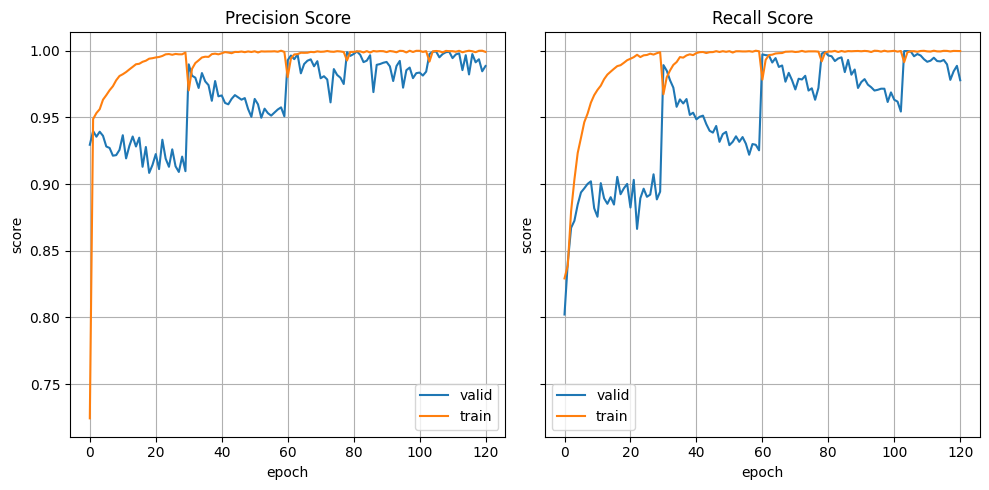

In [414]:
valid_precision_score = [item for history in histories for item in history['val_precision']]
train_precision_score = [item for history in histories for item in history['precision']]
valid_recall_score = [item for history in histories for item in history['val_recall']]
train_recall_score = [item for history in histories for item in history['recall']]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(valid_precision_score, label='valid')
axes[0].plot(train_precision_score, label='train')
axes[0].set_title('Precision Score')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('score')
axes[0].legend()
axes[0].grid()

axes[1].plot(valid_recall_score, label='valid')
axes[1].plot(train_recall_score, label='train')
axes[1].set_title('Recall Score')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('score')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### **7.5. Embedding Model Preparation**

### **7.5.1. Get Dense Embedding Model**

In [388]:
embd_input = Input(shape=(num_dim, ), name='input')
embd_output = training_model.get_layer('shared_node_1')(embd_input)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
Total params: 98560 (385.00 KB)
Trainable params: 98560 (385.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.5.2. Get LSTM Embedding Model**

In [162]:
%%script skipped # Skipped

embd_input = Input(shape=(num_dim, ), name='input')
embd_x = training_model.get_layer('reshape_node_1')(embd_input)
embd_x = training_model.get_layer('shared_node_1')(embd_x)
embd_x = training_model.get_layer('shared_node_2')(embd_x)
embd_output = training_model.get_layer('shared_node_3')(embd_x)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
Total params: 98560 (385.00 KB)
Trainable params: 98560 (385.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.6. Embedding Model Evaluation**

In [389]:
def custom_cosine_similarity(text_1: np.ndarray, text_2: np.ndarray):
    dot_product = np.dot(text_1, text_2)
    norm_text_1 = np.linalg.norm(text_1)
    norm_text_2 = np.linalg.norm(text_2)
    
    similarity = dot_product / (norm_text_1 * norm_text_2)
    return similarity

In [390]:
embd_test_left = embd_model.predict(np.vstack(X_test['text_embedded__left']))
embd_test_right = embd_model.predict(np.vstack(X_test['text_embedded__right']))
embd_similarity = np.array([custom_cosine_similarity(embd_1, embd_2) for embd_1, embd_2 in zip(embd_test_left, embd_test_right)])

1961/1961 [==============================] - 2s 1ms/step


In [394]:
def evaluate_model(similarity_scores: np.ndarray, threshold: float):
  embd_binary_similarity = (similarity_scores > threshold).astype(int)

  precision = precision_score(y_test, embd_binary_similarity)
  recall = recall_score(y_test, embd_binary_similarity)
  f1 = f1_score(y_test, embd_binary_similarity)
  
  return [precision, recall, f1]

In [395]:
threshold_eval = pd.DataFrame([[threshold, *evaluate_model(embd_similarity, threshold)] for threshold in np.linspace(0, 1, 1000)], columns=['threshold', 'precision', 'recall', 'f1'])
threshold_eval.sort_values(by='f1', ascending=False)

,threshold,precision,recall,f1
376,0.376376,0.918620,0.900710,0.909577
385,0.385385,0.929024,0.890639,0.909426
377,0.377377,0.919372,0.899548,0.909352
375,0.375375,0.917225,0.901356,0.909221
378,0.378378,0.920249,0.898386,0.909186
...,...,...,...,...
995,0.995996,1.000000,0.020400,0.039985
996,0.996997,1.000000,0.020013,0.039241
997,0.997998,1.000000,0.019496,0.038247
998,0.998999,1.000000,0.019367,0.037999


<Axes: title={'center': 'Metrics Evaluation'}, xlabel='Threshold', ylabel='Metric score'>

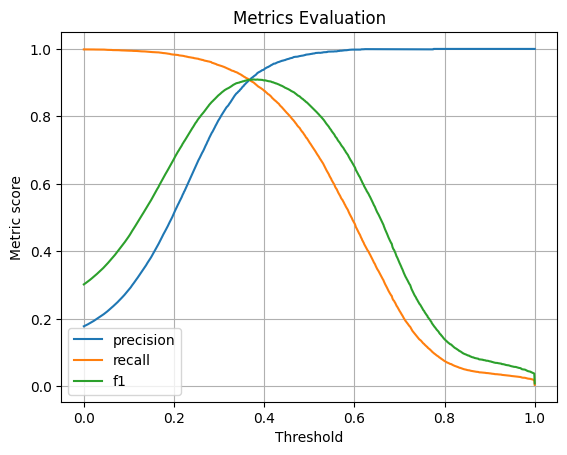

In [397]:
threshold_eval.plot(
  kind='line',
  title='Metrics Evaluation',
  x='threshold',
  xlabel='Threshold',
  ylabel='Metric score',
  grid=True)

In [483]:
model_eval = evaluate_model(embd_similarity, 0.376376)

print(f'Precision: {model_eval[0]:.5f}')
print(f'Recall: {model_eval[1]:.5f}')
print(f'F1: {model_eval[2]:.5f}')

Precision: 0.91862
Recall: 0.90071
F1: 0.90958


### **8. Similarity Search**

### **8.1. Prepare Data**

In [449]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
  'id__right': 'id_match',
}

df_sim_search_test = df[df['label'] == 1][['id__left', 'text_embedded__left', 'id__right']].rename(columns=column_mapper)
df_sim_search_test

,id,vector,id_match
5,416997,"[-0.072986886, -0.048403066, -0.05239149, 0.03...",409704.0
11,417394,"[0.0004796597, -0.03494158, 0.02467686, 0.0704...",414846.0
12,923579,"[-0.0062303515, -0.034742985, 0.023416176, 0.0...",911158.0
27,1269834,"[-0.0050008707, -0.026148036, 0.0021574006, 0....",1260763.0
29,1632001,"[-0.028161129, -0.02929935, 0.036383927, 0.069...",1664120.0
...,...,...,...
209071,547422,"[-0.04709348, 0.033390395, 0.061012138, 0.0247...",547418.0
209084,266505,"[-0.065609306, 0.026629083, -0.044262823, 0.03...",204519.0
209096,322669,"[0.024973787, -0.060527463, -0.005482184, 0.02...",259362.0
209101,219511,"[0.012483932, -0.061094485, 0.0012884644, 0.02...",210910.0


In [450]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
}

df_sim_search_data = df[['id__left', 'text_embedded__left']].rename(columns=column_mapper)
df_sim_search_data = df_sim_search_data[~df_sim_search_data['id'].isin(df_sim_search_test['id'])]
df_sim_search_data

,id,vector
0,1279257,"[-0.0022593888, -0.044363864, 0.06777612, 0.00..."
1,1141385,"[-0.007411764, -0.013490342, 0.019699965, 0.05..."
2,1703386,"[-0.08651987, -0.012659603, 0.08617276, 0.0153..."
3,414919,"[-0.09629384, 0.07576377, 0.014162948, 0.00260..."
4,308978,"[0.018577315, -0.020130774, -0.001404795, -0.0..."
...,...,...
209116,668453,"[-0.039439715, 0.012647993, -0.007290032, 0.07..."
209117,495107,"[-0.04159561, -0.04965289, 0.048648275, -0.029..."
209118,449563,"[0.009493686, -0.007985604, 0.028533928, 0.015..."
209119,1044403,"[-0.045551524, -0.020288467, -0.026136968, 0.0..."


### **8.2. Create Faiss Index**

In [454]:
vectors = np.vstack(df_sim_search_data['vector'])
ids = df_sim_search_data['id']

nlist = 100
quantizer = faiss.IndexFlatL2(num_dim)
index = faiss.IndexIVFFlat(quantizer, num_dim, nlist)

index.train(vectors)

faiss.normalize_L2(vectors)
index.add_with_ids(vectors, ids)

### **8.3. Perform Similarity Search**

In [480]:
index.nprobe = 10
k = 5

_vector = np.vstack(df_sim_search_test['vector'])
search_result = index.search(_vector, k=k)

### **8.4. Similarity Search Evaluation**

In [481]:
ids_actual = search_result[1]
ids_expected = df_sim_search_test['id_match']

results = []
for id_actual, id_expected in zip(ids_actual, ids_expected):
  if id_expected in id_actual:
    results.append(1)
  else:
    results.append(0)

In [482]:
np.average(results)

0.21846070418716348